In [1]:
import os
import random
import gc
import argparse
import numpy as np
import h5py as h5
import torch
import torch.nn.functional as F
import wandb

from models.autoencoder import Autoencoder 
from losses.cyl_ptpz_mae import CylPtPzMAE

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [2]:
#setting a seed like in ae_legacy
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def distance_corr(var_1,var_2,normedweight,power=1):
    """var_1: First variable to decorrelate (eg mass)
    var_2: Second variable to decorrelate (eg classifier output)
    normedweight: Per-example weight. Sum of weights should add up to N (where N is the number of examples)
    power: Exponent used in calculating the distance correlation
    
    va1_1, var_2 and normedweight should all be 1D torch tensors with the same number of entries
    
    Usage: Add to your loss function. total_loss = BCE_loss + lambda * distance_corr
    """ 
    
    xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()

    xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    
    return dCorr

In [4]:
#calculates anomaly score like in ae legacy
def distance_pt(model_ae, data_np, device):
    x = torch.tensor(data_np, dtype=torch.float32, device=device)
    z_mean, z_logvar, _ = model_ae.encoder(x)
    score = torch.sum(z_mean**2, dim=1)
    return score.detach().cpu().numpy()

In [5]:
#function to make 2D histograms
def make_2D_hist(x, y, xlabel, ylabel, title, wandb_key, bins=40):
    fig = plt.figure(figsize=(5,4))
    plt.hist2d(x, y, bins=bins)
    plt.colorbar(label='Counts')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    wandb.log({wandb_key: wandb.Image(fig)})
    plt.close(fig)

In [10]:
#prints h5 tree to examine
def print_h5_tree(h, prefix=""):
    for k in h.keys():
        item = h[k]
        if hasattr(item, 'keys'):
            print(prefix + f"[GROUP] {k}")
            print_h5_tree(item, prefix + "  ")
        else:
            try:
                print(prefix + f"{k}: shape={item.shape}, dtype={item.dtype}")
            except Exception:
                print(prefix + f"{k}: <dataset>")

In [11]:
def inference_loss_plots(ae_1, ae_2, dataset_test, reco_loss_fn, device, batch_size=2048, outdir="plots", bins=200, logy=False):
    # Ensure output directory exists (for saving plot files)
    os.makedirs(outdir, exist_ok=True)

    #put aes in evaluation mode
    ae_1.eval()
    ae_2.eval()

    #move to device
    X = torch.tensor(dataset_test, dtype=torch.float32, device=device)

    #per batch loss arrays
    losses_1 = []
    losses_2 = []

    with torch.no_grad():
        # Iterate over test data in batches to control memory usage
        for i in range(0, X.size(0), batch_size):
            xb = X[i:i + batch_size]

            #forward pass
            recon1, _ = ae_1(xb)
            recon2, _ = ae_2(xb)

            #compute per-sample reconstruction losses
            l1 = reco_loss_fn(recon1, xb).detach().cpu().numpy().reshape(-1)
            l2 = reco_loss_fn(recon2, xb).detach().cpu().numpy().reshape(-1)

            losses_1.append(l1)
            losses_2.append(l2)

    #concatenate all batch chunks (full per-event loss arrays)
    losses_1_all = np.concatenate(losses_1, axis=0)
    losses_2_all = np.concatenate(losses_2, axis=0)

    #save raw arrays
    np.save(os.path.join(outdir, "test_reco_loss_ae1.npy"), losses_1_all)
    np.save(os.path.join(outdir, "test_reco_loss_ae2.npy"), losses_2_all)

    # 1) keep only positive values (log axes can’t show <= 0)
    mask = (losses_1_all > 0) & (losses_2_all > 0)
    x1 = losses_1_all[mask]
    x2 = losses_2_all[mask]

    # 2) build LOG-SPACED bin edges (not linspace) so bars look right on log axes
    nbins = bins  # reuse your function arg
    x1_max = np.nextafter(float(x1.max()), np.inf)  # include max in last bin
    x2_max = np.nextafter(float(x2.max()), np.inf)
    edges1 = np.logspace(np.log10(float(x1.min())), np.log10(x1_max), nbins + 1)
    edges2 = np.logspace(np.log10(float(x2.min())), np.log10(x2_max), nbins + 1)

    # --- AE1 histogram (log x; optional log y if counts span decades) ---
    plt.figure(figsize=(7, 4))
    plt.hist(x1, bins=edges1)
    plt.xscale("log")
    # plt.yscale("log")  # uncomment if you want log counts too
    plt.xlabel("AE1 reconstruction loss"); plt.ylabel("Counts")
    plt.title("AE1 reconstruction loss (Test)")
    plt.xlim(edges1[0], edges1[-1])
    plt.tight_layout()

    # --- AE2 histogram ---
    plt.figure(figsize=(7, 4))
    plt.hist(x2, bins=edges2)
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("AE2 reconstruction loss"); plt.ylabel("Counts")
    plt.title("AE2 reconstruction loss (Test)")
    plt.xlim(edges2[0], edges2[-1])
    plt.tight_layout()

    # --- 2D histogram (log x, log y, log color for counts) ---
    plt.figure(figsize=(6, 5))
    h2, xe, ye, im = plt.hist2d(
        x1, x2,
        bins=[edges1, edges2],
        norm=LogNorm(vmin=1),  # avoids log(0) and reveals structure
        cmin=1                 # drop empty bins
    )
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("AE1 reconstruction loss"); plt.ylabel("AE2 reconstruction loss")
    plt.title("AE1 vs AE2 reconstruction loss (Test) — log-log")
    plt.xlim(edges1[0], edges1[-1]); plt.ylim(edges2[0], edges2[-1])
    plt.colorbar(label="Counts (log)")
    plt.tight_layout()

    # ====== END REPLACEMENT ======

    return losses_1_all, losses_2_all

    #noon log plots
    # USE_FIXED_RANGE = False
    # USE_ROBUST = False
    # if USE_FIXED_RANGE:
    #     xlo1, xhi1 = 0.0, 300.0
    #     xlo2, xhi2 = 0.0, 300.0
    # elif USE_ROBUST:
    #     # robust (1–99th pct) if you prefer autoscaling
    #     xlo1, xhi1 = np.percentile(losses_1_all, [1, 99])
    #     xlo2, xhi2 = np.percentile(losses_2_all, [1, 99])
    # else:
    #     xlo1 = float(np.nanmin(losses_1_all)); xhi1 = float(np.nanmax(losses_1_all))
    #     xlo2 = float(np.nanmin(losses_2_all)); xhi2 = float(np.nanmax(losses_2_all))
        
    #     # pad the top edge by 1 ULP so the max is guaranteed inside the last bin
    #     xhi1_pad = np.nextafter(xhi1, np.float64(np.inf))
    #     xhi2_pad = np.nextafter(xhi2, np.float64(np.inf))
    
    # # --- build edges (many bins!) ---
    # n_bins = 500
    # edges1 = np.linspace(xlo1, xhi1_pad, n_bins + 1)
    # edges2 = np.linspace(xlo2, xhi2_pad, n_bins + 1)
    
    # # 1) AE1 histogram
    # plt.figure(figsize=(7,4))
    # counts1, e1, _ = plt.hist(losses_1_all, bins=edges1)  # edges, not a 2-tuple
    # plt.xlabel("AE1 reconstruction loss"); plt.ylabel("Counts")
    # plt.title("AE1 reconstruction loss (Test)")
    # plt.xlim(xlo1, xhi1)
    # #plt.yscale("log")
    # plt.xscale("log")
    # plt.tight_layout()
    # #plt.savefig(ae1_png, dpi=150); plt.close()
    
    # # 2) AE2 histogram
    # plt.figure(figsize=(7,4))
    # counts2, e2, _ = plt.hist(losses_2_all, bins=edges2)
    # plt.xlabel("AE2 reconstruction loss"); plt.ylabel("Counts")
    # plt.title("AE2 reconstruction loss (Test)")
    # plt.xlim(xlo2, xhi2)
    # #plt.yscale("log")
    # plt.xscale("log")
    # plt.tight_layout()
    # #plt.savefig(ae2_png, dpi=150); plt.close()
    
    # # 3) 2D histogram
    # plt.figure(figsize=(6,5))
    # h2, xe, ye, im = plt.hist2d(
    #     losses_1_all, losses_2_all,
    #     bins=[edges1, edges2],                   # explicit edges for both axes
    #     range=[[xlo1, xhi1_pad], [xlo2, xhi2_pad]],      # keep axes fixed
    #     norm=LogNorm()                            # optional: better dynamic range
    # )
    # plt.xlabel("AE1 reconstruction loss"); plt.ylabel("AE2 reconstruction loss")
    # plt.title("AE1 vs AE2 reconstruction loss (Test)")
    # plt.yscale("log")
    # plt.xscale("log")
    # #plt.xlim(xlo1, xhi1); plt.ylim(xlo2, xhi2)
    # plt.colorbar(label="Counts")
    # plt.tight_layout()
    # #plt.savefig(both2d_png, dpi=150); plt.close()
    # #returns arrays
    # return losses_1_all, losses_2_all


In [12]:
def run(config):
    #set seed
    seed = 123
    set_seed(seed)

    #move to gpu if avail
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")

    #login to wandb
    print("Logging in to wandb...")
    wandb.login(key="24d1d60ce26563c74d290d7b487cb104fc251271")
    wandb.init(project="Double Disco Axo Training",
               settings=wandb.Settings(_disable_stats=True),
               config=config)
    run_name = wandb.run.name
    print(f"Run name: {run_name}")

    #scaling
    alpha = float(config['alpha'])
    ae_lr = float(config['ae_lr'])

    #load data from l1 h5 data
    print("Loading dataset...")
    #fpath = '/axovol/training/v5/conditionsupdate_apr25.h5'
    fpath = '/axovol/2024I_preprocessed_10.h5'
    with h5.File(fpath, 'r') as f:
        root = f['data'] if 'data' in f else f

        #print h5 tree to view
        print("Printing h5 tree...")
        print_h5_tree(root)
    
        x_train = root['Background_data']['Train']['DATA'][:]
        x_test = root['Background_data']['Test']['DATA'][:]
        print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
    
        #flatten per event
        x_train_bkg = x_train.reshape(x_train.shape[0], -1)
        x_test_bkg  = x_test.reshape(x_test.shape[0], -1)
    
        scale = root['Normalization']['norm_scale'][:]
        bias = root['Normalization']['norm_bias'][:]
    
        # l1_bits_bkg_test = root['Background_data']['Test']['L1bits'][:]
    
        # #load signal data
        # SIGNAL_NAMES = list(root['Signal_data'].keys())
        # signal_data_dict = {}
        # signal_l1_dict = {}
        # for sname in SIGNAL_NAMES:
        #     x_sig = root['Signal_data'][sname]['DATA'][:]
        #     x_sig = x_sig.reshape(x_sig.shape[0], -1)
        #     l1_bits = root['Signal_data'][sname]['L1bits'][:]
        #     signal_data_dict[sname] = x_sig
        #     signal_l1_dict[sname] = l1_bits

    print("Data finished loading.")
    
    dataset = x_train_bkg
    dataset_test = x_test_bkg

    #should be 57
    features = dataset.shape[1]


    print("Building mask...")
    # same mask from ae legacy
    mask_dict = {
        "MET":[True],
        "EGAMMA":[True,True,True,True,False,False,False,False,False,False,False,False],
        "MUON":[True,True,True,True,False,False,False,False],
        "JET":[True,True,True,True,True,True,True,True,True,True,False,False]
    }
    
    #build cyl_ptpz_mae mask (input scales and biases)
    reco_loss_fn = CylPtPzMAE(scale, bias).to(device)
    print("Mask is ready.")


    #ae config
    latent_dim = int(config['ae_latent'])
    enc_nodes = list(config['ae_nodes'])
    dec_nodes = [24, 32, 64, 128, features] 

    ae_cfg = {
        "features": features,
        "latent_dim": latent_dim,
        "encoder_config": {"nodes": enc_nodes},
        "decoder_config": {"nodes": dec_nodes},
        "alpha": alpha
    }

    #put ae on device/init
    ae_1 = Autoencoder(ae_cfg).to(device)
    ae_2 = Autoencoder(ae_cfg).to(device)
    print("Autoencoders are ready.")

    #optimizer (adam)
    optimizer = torch.optim.Adam(list(ae_1.parameters()) + list(ae_2.parameters()), lr=ae_lr)

    #cosine restarts
    warmup_epochs = 10
    cos = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=32, T_mult=2, eta_min=0.0)

    #sets learning rate
    def set_lr(lr):
        for g in optimizer.param_groups:
            g['lr'] = lr

    #hyperparameters
    Epochs_AE = 40
    Batch_size = 1024

    #get disco param from config, else set to 1
    lambda_disco = float(config.get("lambda_disco", 1))

    print("Moving data to device...")
    X = torch.tensor(dataset, dtype=torch.float32, device=device)
    print("Data on device.")

    #training loop
    print("Starting the training loop!")
    N = X.size(0)
    for epoch in range(Epochs_AE):

        #init lists for 2D plotting
        ae1_reco_loss = []
        ae2_reco_loss = []
        
        #cosine warmup step (sets the learning rate based on cosine schedule)
        if epoch < warmup_epochs:
            lr = ae_lr * (epoch + 1) / warmup_epochs
            set_lr(lr)
        else:
            cos.step(epoch - warmup_epochs)

        #shuffles data incides for each epoch
        perm = torch.randperm(N, device=device)

        #init losses
        total_loss = total_reco1 = total_reco2 = total_disco = 0.0

        #loops over dataset in steps of batch sizze
        for i in range(0, N, Batch_size):
            #picks indices for current batch
            idx = perm[i:i+Batch_size]

            #selects batch of samples from data set X
            xb = X[idx]

            #ae 1
            recon1, z1 = ae_1(xb)
            
            #ae 2
            recon2, z2 = ae_2(xb)

            #get reco loss from custom func
            reco1_per = reco_loss_fn(recon1, xb)
            reco2_per = reco_loss_fn(recon2, xb)

            #from paper code weight
            B = xb.shape[0]
            w = torch.ones(B, device=reco1_per.device, dtype=reco1_per.dtype)

            #disco loss (ask Melissa about since using mu instead of z)
            #disco = disco_loss(mu1, mu2)
            disco = distance_corr((reco1_per), (reco2_per), w, power=1)

            #same scaling from ae legacy
            reco1 = ae_1.alpha*reco1_per.mean()
            reco2 = ae_2.alpha*reco2_per.mean()

            #calc total loss (scalar)
            loss = reco1 + reco2 + lambda_disco * disco

            #zero grads
            optimizer.zero_grad(set_to_none=True)

            #backward pass
            loss.backward()

            #do some gradient clipping
            torch.nn.utils.clip_grad_norm_(list(ae_1.parameters()) + list(ae_2.parameters()), max_norm=5.0)
            optimizer.step()

            #add losses to list for wandb plotting
            total_loss+=loss.item()
            total_reco1+=reco1.item()
            total_reco2+=reco2.item()
            total_disco+=disco.item()

            #add loss to list for 2d plotting
            ae1_reco_loss.append(reco1.item())
            ae2_reco_loss.append(reco2.item())

        print(f"[EPOCH {epoch}/{Epochs_AE}] "
          f"Loss={total_loss:.4f} "
          f"Reco1={total_reco1:.4f} Reco2={total_reco2:.4f} "
          f"DisCo={total_disco:.4f}")

        #log in wandb
        wandb.log({
            "Epochae": epoch,
            "TotalLossae": total_loss,
            "RecoLossae1": total_reco1,
            "RecoLossae2": total_reco2,
            "DisCoLoss": total_disco,
        })

        #convert to np array for plot
        ae1_reco_np = np.array(ae1_reco_loss)
        ae2_reco_np = np.array(ae2_reco_loss)

        make_2D_hist(ae1_reco_np, ae2_reco_np,
                    "Reco Loss (ae1)", "Reco Loss (ae2)",
                    f"Epoch {epoch}: Reco ae1 vs Reco ae2",
                    wandb_key="Hists2D/Reco_ae1_vs_Reco_ae2")

    

    print("Finished training.")

    #save models
    torch.save(ae_1.state_dict(), "ae1_trained.pth")
    torch.save(ae_2.state_dict(), "ae2_trained.pth")

    _ae1_losses, _ae2_losses = inference_loss_plots(
        ae_1, ae_2,
        dataset_test=dataset_test,
        reco_loss_fn=reco_loss_fn,
        device=device,
        batch_size=2048,
        outdir="plots",
        bins= 200,
        logy=False
    )

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Using: cuda:0
Logging in to wandb...


DisCoLoss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epochae,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
RecoLossae1,█▆▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RecoLossae2,██▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TotalLossae,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
DisCoLoss,0.76508
Epochae,39
RecoLossae1,43181.02155
RecoLossae2,48667.66123
TotalLossae,168356.46516


Run name: floral-sunset-162
Loading dataset...
Printing h5 tree...
[GROUP] Background_data
  [GROUP] Test
    DATA: shape=(255856, 33, 3), dtype=float32
  [GROUP] Train
    DATA: shape=(1023420, 33, 3), dtype=float32
[GROUP] Normalization
  norm_bias: shape=(33, 3), dtype=float32
  norm_scale: shape=(33, 3), dtype=float32
Train shape: (1023420, 33, 3), Test shape: (255856, 33, 3)
Data finished loading.
Building mask...
Mask is ready.
Autoencoders are ready.
Moving data to device...
Data on device.
Starting the training loop!
[EPOCH 0/40] Loss=10506380.7375 Reco1=104887.2069 Reco2=113322.4086 DisCo=102.8817
[EPOCH 1/40] Loss=827385.9967 Reco1=83500.9148 Reco2=109678.2537 DisCo=6.3421
[EPOCH 3/40] Loss=421703.8204 Reco1=66628.9296 Reco2=85942.8179 DisCo=2.6913
[EPOCH 4/40] Loss=360463.7758 Reco1=65242.5528 Reco2=82145.8761 DisCo=2.1308
[EPOCH 5/40] Loss=329631.5164 Reco1=64408.6306 Reco2=78865.9303 DisCo=1.8636
[EPOCH 6/40] Loss=325333.3003 Reco1=64690.6503 Reco2=74634.2771 DisCo=1.8601


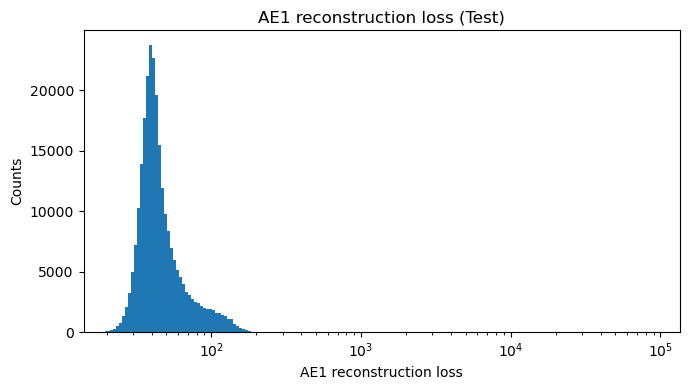

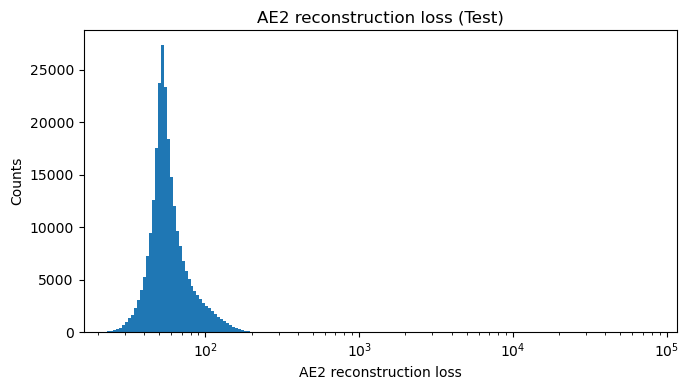

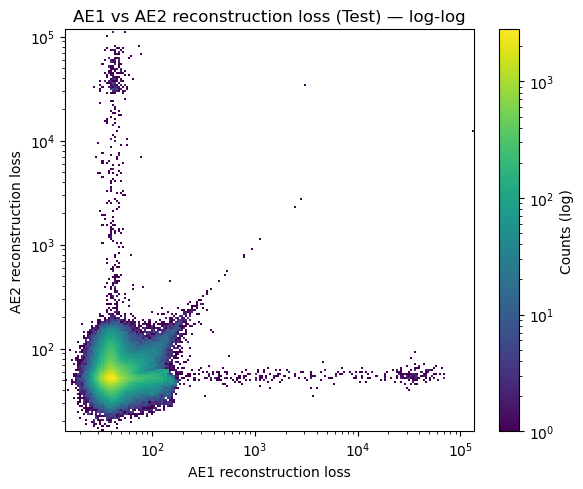

In [13]:
config = {
    'ae_lr': 1e-4,
    'alpha': 0.5,
    'ae_latent': 8,
    'ae_nodes': [28, 14],
    'lambda_disco': 100000.0
}

run(config)